In [3]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("data/datasetnowall.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

In [94]:
map_img = io.imread("data/map_nowalls.png")
map_img = map_img /254

Uniform data

In [3]:
def uniform_rotation(db):
    unidir_map = []
    counter = 0
    buffer = []
    corr_angle = 0

    for i in db:
        i[2] = np.around((((i[2]+i[6]) + np.pi) % (2*np.pi))-np.pi,decimals=5)
        i[6] = 0
        buffer.append(i)
        if counter == 719:
            if corr_angle != 0:
                for j in range(720):
                    buffer[(j+corr_angle)%720][2]=np.radians((j-360)/2)

            buffer.sort(key= lambda i:i[2])
            unidir_map.append(buffer.copy())
            counter = 0
            buffer = []
        else:
            counter += 1

    return unidir_map

In [4]:
laser_db_unidir = uniform_rotation(laser_db.values)

In [5]:
with open('datasetnowall_unidir.csv', 'w') as f:
    f.write("cnt;time;angle;range;pos_x;pos_y;pos_yaw\n")
    for laser in laser_db_unidir:
        for item in laser:
            f.write("{};{};{};{};{};{};{}\n".format(item[0],item[1],item[2],item[3],item[4],item[5],item[6]))
       

Visualize coordinates

In [10]:
cnt = 1
pnt_list = []
for i in laser_db.values:
    if i[0] == cnt:
        pnt_list.append([i[4],i[5]])
        cnt += 1

In [89]:
def pnt_on_grid(map_img, pnt, rad=1):
    #rad = 1 esatta
    map_grid = np.zeros(map_img.shape)

    coord_x = pnt[0] / 0.05
    coord_y = pnt[1] / 0.05

    px_mod = 0

    for r in range(rad):
        for i in range(360):
            x=int(np.cos(np.radians(i))*r)
            y=int(np.sin(np.radians(i))*r)

            int_x = int(coord_x+x)
            int_y = int(coord_y+y)

            if int_x >= 0 and int_x < map_grid.shape[1] and int_y >= 0 and int_y < map_grid.shape[0] and map_grid[int_y][int_x]==0:
                map_grid[int_y][int_x] = 1/(1+np.abs(x)+np.abs(y))
                px_mod += 1/(1+np.abs(x)+np.abs(y))

    for i in range(map_grid.shape[0]):
        for j in range(map_grid.shape[1]):
            if map_grid[i][j]!= 0:
                map_grid[i][j] = map_grid[i][j]/px_mod

    return map_grid

In [95]:
result_map = pnt_on_grid(map_img,pnt_list[597],2)

In [96]:
for i in range(result_map.shape[0]):
    for j in range(result_map.shape[1]):
        map_img[i][j] -= result_map[i][j]

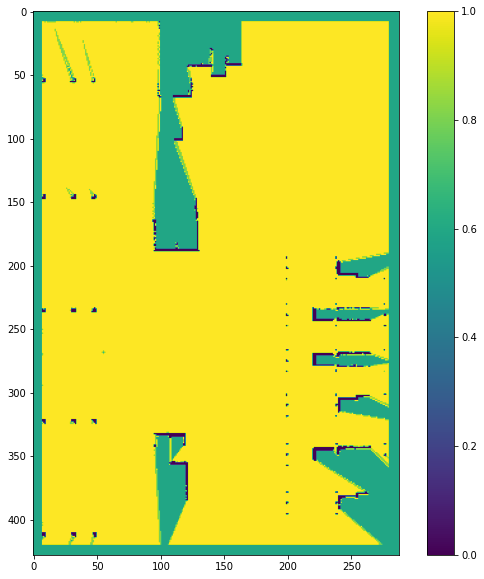

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()